# Introduction 

I will prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. I have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

# Importing all the libraries

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

# Preparing the data

In [2]:
# Load datasets
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

# Display basic information about the datasets
print("Training Data")
print(train_data.info())
print(train_data.head())

print("\nTest Data")
print(test_data.info())
print(test_data.head())

print("\nFull Data")
print(full_data.info())
print(full_data.head())


Training Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-

In [3]:
# Load the datasets
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

# Extract necessary columns for recovery calculation
C = train_data['rougher.output.concentrate_au']
F = train_data['rougher.input.feed_au']
T = train_data['rougher.output.tail_au']

# Calculate the recovery using the provided formula
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100

# Provided recovery values
provided_recovery = train_data['rougher.output.recovery']

# Calculate MAE between provided and calculated recovery
mae = mean_absolute_error(provided_recovery.dropna(), calculated_recovery[provided_recovery.notna()])

mae


9.303415616264301e-15

The provided recovery values (rougher.output.recovery) match the calculated values with an extremely low error, indicating the correctness of the recovery formula applied.

In [4]:
# Identify features present in the training set but absent in the test set
missing_in_test = set(train_data.columns) - set(test_data.columns)

# Display the missing features
print("Features present in training data but missing in test data:")
print(missing_in_test)

# Determine the types of these missing features
missing_features_types = train_data[list(missing_in_test)].dtypes
print("\nTypes of missing features:")
print(missing_features_types)


Features present in training data but missing in test data:
{'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.tail_sol', 'rougher.output.recovery', 'primary_cleaner.output.concentrate_pb', 'final.output.tail_au', 'final.output.tail_sol', 'final.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_sol', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'rougher.output.tail_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_ag', 'rougher.output.concentrate_au', 'primary_cleaner.output.tail_au', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_ag', 'final.output.concentrate_sol', 'final.output.concentrate_pb', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_pb', 'rougher.output.tail_ag', 'primary_cleaner.output.concentrate_ag', '

In [5]:
# Convert 'date' column to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
full_data['date'] = pd.to_datetime(full_data['date'])

# Drop rows with missing target values in the training data
train_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

# Handling missing values with forward fill
train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

# Separate features and target variables in training data
target_columns = ['rougher.output.recovery', 'final.output.recovery']
features_train = train_data.drop(columns=target_columns)
targets_train = train_data[target_columns]

# Standardize the features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train.drop(columns=['date']))

# Converting back to DataFrame
features_train_scaled_df = pd.DataFrame(features_train_scaled, columns=features_train.columns.drop('date'))

# Display the processed data
print(features_train_scaled_df.head())
print(targets_train.head())


   final.output.concentrate_ag  final.output.concentrate_pb  \
0                     0.666992                    -0.146960   
1                     0.647983                    -0.099043   
2                     0.667374                     0.049035   
3                     0.661570                    -0.094164   
4                     0.735041                     0.005839   

   final.output.concentrate_sol  final.output.concentrate_au  \
0                     -1.247732                    -0.369366   
1                     -1.334174                    -0.265472   
2                     -1.290536                    -0.274468   
3                     -1.472439                    -0.267879   
4                     -1.444457                    -0.250689   

   final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0              0.347103             -1.716775               2.128453   
1              0.368972             -1.684219               2.038638   
2              0.388

# Analyzing the data

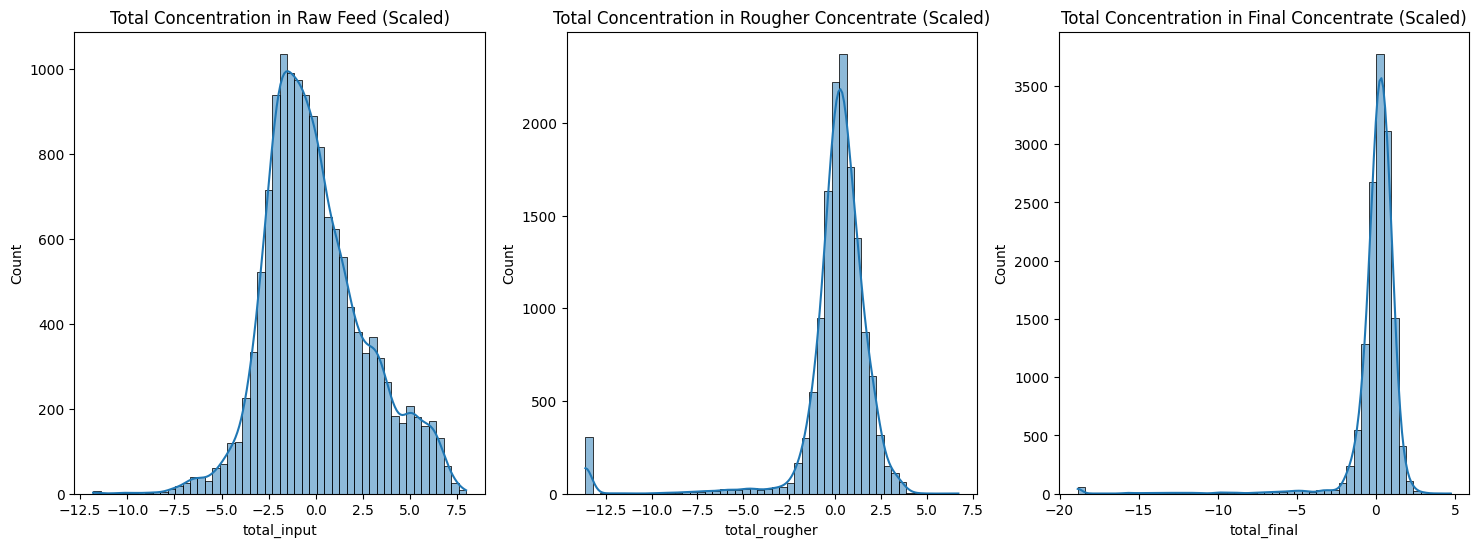

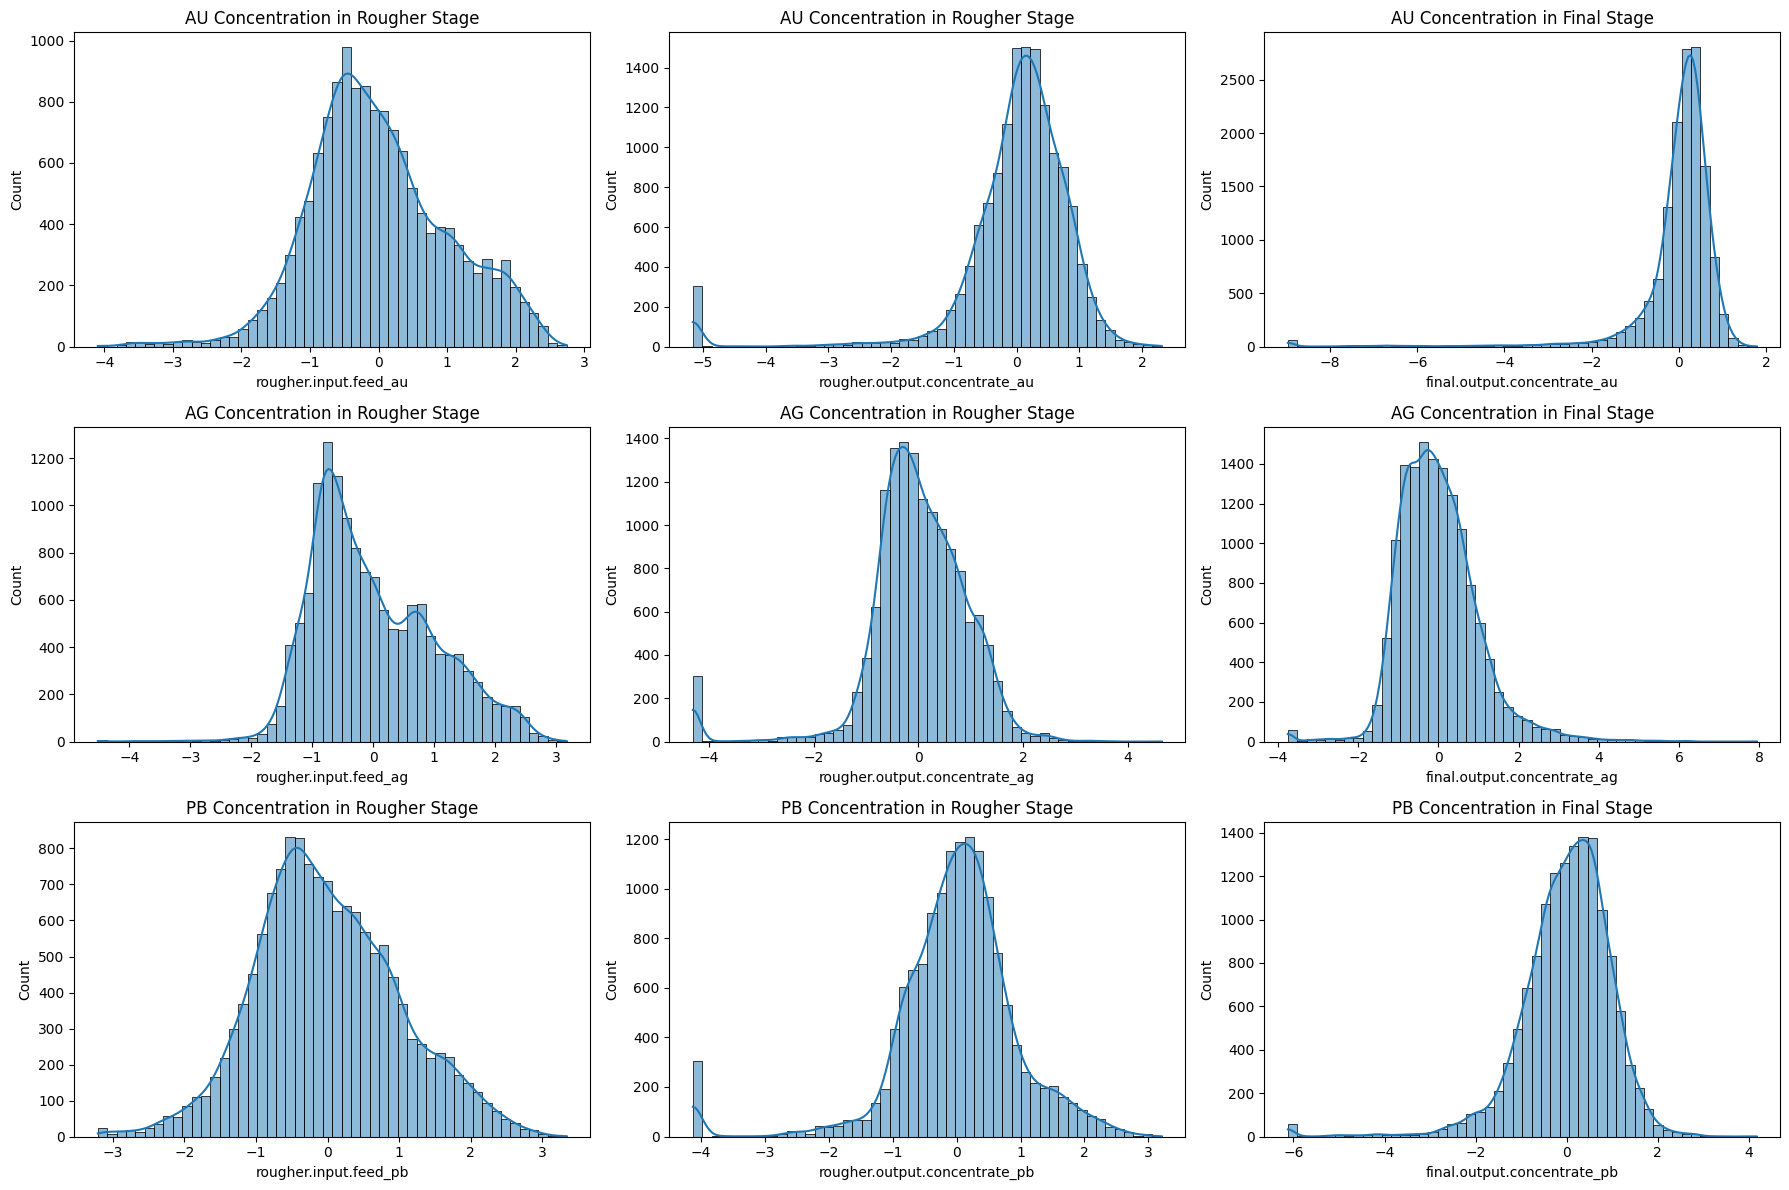

In [6]:
# Calculate total concentration of metals at each stage using scaled features
features_train_scaled_df['total_input'] = features_train_scaled_df[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
features_train_scaled_df['total_rougher'] = features_train_scaled_df[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
features_train_scaled_df['total_final'] = features_train_scaled_df[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Plot the distributions of total concentrations
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(features_train_scaled_df['total_input'], bins=50, kde=True)
plt.title('Total Concentration in Raw Feed (Scaled)')

plt.subplot(1, 3, 2)
sns.histplot(features_train_scaled_df['total_rougher'], bins=50, kde=True)
plt.title('Total Concentration in Rougher Concentrate (Scaled)')

plt.subplot(1, 3, 3)
sns.histplot(features_train_scaled_df['total_final'], bins=50, kde=True)
plt.title('Total Concentration in Final Concentrate (Scaled)')

plt.show()

# Plot concentrations of individual metals (Au, Ag, Pb) at each stage
plt.figure(figsize=(18, 12))

metals = ['au', 'ag', 'pb']
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']

for i, metal in enumerate(metals, 1):
    for j, stage in enumerate(stages, 1):
        plt.subplot(3, 3, (i-1)*3 + j)
        sns.histplot(features_train_scaled_df[f'{stage}_{metal}'], bins=50, kde=True)
        plt.title(f'{metal.upper()} Concentration in {stage.split(".")[0].capitalize()} Stage')

plt.tight_layout()
plt.show()


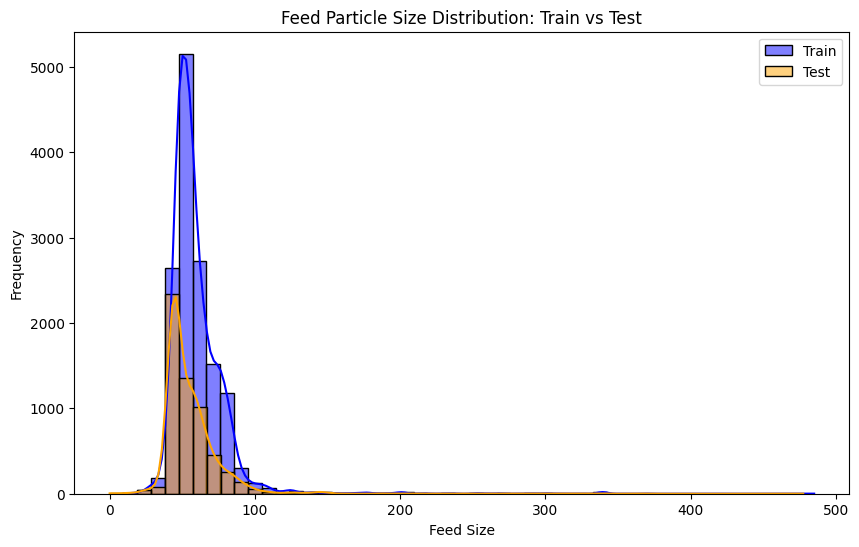

K-S Statistic: 0.2459
P-Value: 0.0000
The feed particle size distributions in the training and test sets are significantly different (p < 0.05).


In [7]:
# Plot histograms for visual comparison of feed particle size distributions
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rougher.input.feed_size'], bins=50, color='blue', label='Train', kde=True)
sns.histplot(test_data['rougher.input.feed_size'], bins=50, color='orange', label='Test', kde=True)
plt.legend()
plt.title('Feed Particle Size Distribution: Train vs Test')
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.show()

# Perform Kolmogorov-Smirnov test
ks_statistic, ks_p_value = ks_2samp(train_data['rougher.input.feed_size'], test_data['rougher.input.feed_size'])

print(f'K-S Statistic: {ks_statistic:.4f}')
print(f'P-Value: {ks_p_value:.4f}')

if ks_p_value < 0.05:
    print("The feed particle size distributions in the training and test sets are significantly different (p < 0.05).")
else:
    print("The feed particle size distributions in the training and test sets are not significantly different (p >= 0.05).")


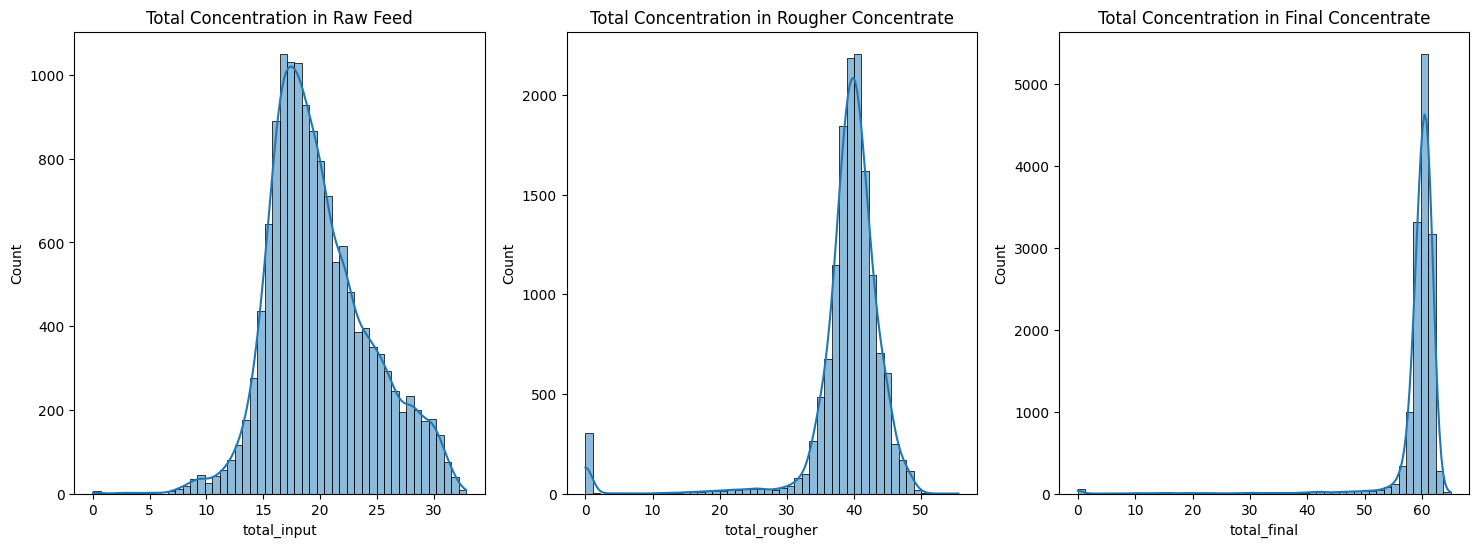

In [8]:
# Calculate total concentration of metals at each stage
train_data['total_input'] = train_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_data['total_rougher'] = train_data[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_data['total_final'] = train_data[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Plot the distributions
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(train_data['total_input'], bins=50, kde=True)
plt.title('Total Concentration in Raw Feed')

plt.subplot(1, 3, 2)
sns.histplot(train_data['total_rougher'], bins=50, kde=True)
plt.title('Total Concentration in Rougher Concentrate')

plt.subplot(1, 3, 3)
sns.histplot(train_data['total_final'], bins=50, kde=True)
plt.title('Total Concentration in Final Concentrate')

plt.show()


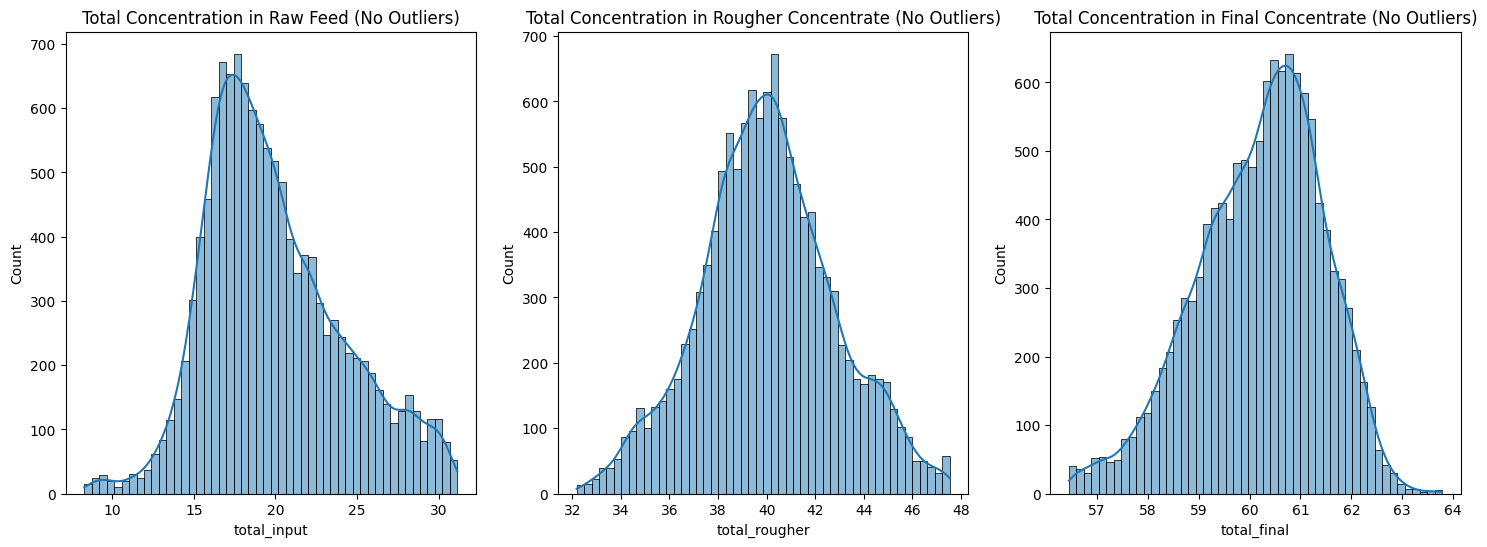

In [9]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in total concentrations
train_data_no_outliers = remove_outliers(train_data, 'total_input')
train_data_no_outliers = remove_outliers(train_data_no_outliers, 'total_rougher')
train_data_no_outliers = remove_outliers(train_data_no_outliers, 'total_final')

# Plot the distributions after removing outliers
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(train_data_no_outliers['total_input'], bins=50, kde=True)
plt.title('Total Concentration in Raw Feed (No Outliers)')

plt.subplot(1, 3, 2)
sns.histplot(train_data_no_outliers['total_rougher'], bins=50, kde=True)
plt.title('Total Concentration in Rougher Concentrate (No Outliers)')

plt.subplot(1, 3, 3)
sns.histplot(train_data_no_outliers['total_final'], bins=50, kde=True)
plt.title('Total Concentration in Final Concentrate (No Outliers)')

plt.show()


The removal of outliers has resulted in cleaner and more consistent distributions for the total concentrations of metals at different stages. This should help improve the model's performance by reducing the impact of anomalous data points.

# Build the model

In [10]:
def smape(y_true, y_pred):
    """
    Calculate sMAPE (Symmetric Mean Absolute Percentage Error).
    """
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = (numerator / denominator).mean() * 100
    return smape_value

def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    """
    Calculate the final sMAPE value using the given weights.
    """
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    final_smape_value = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape_value


In [14]:
# Separate features and target variables in training data
target_columns = ['rougher.output.recovery', 'final.output.recovery']
features_train = train_data.drop(columns=target_columns)
targets_train = train_data[target_columns]

# Filter out columns that are not in the test set
common_columns = features_train.columns.intersection(test_data.columns).drop('date')
features_train_filtered = features_train[common_columns]

# Standardize the features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_filtered)

# Converting back to DataFrame
features_train_scaled_df = pd.DataFrame(features_train_scaled, columns=common_columns)

# Separate the target columns for rougher and final recovery
target_rougher = targets_train['rougher.output.recovery']
target_final = targets_train['final.output.recovery']

# Define the RandomForestRegressor models
model_rougher = RandomForestRegressor(n_estimators=10, random_state=42)
model_final = RandomForestRegressor(n_estimators=10, random_state=42)

# Define sMAPE scorer for cross-validation
smape_scorer = make_scorer(smape, greater_is_better=False)

# Perform cross-validation
print("Starting Cross-Validation for Rougher Model...")
scores_rougher = cross_val_score(model_rougher, features_train_scaled_df, target_rougher, cv=3, scoring=smape_scorer)
print("Finished Cross-Validation for Rougher Model...")

print("Starting Cross-Validation for Final Model...")
scores_final = cross_val_score(model_final, features_train_scaled_df, target_final, cv=3, scoring=smape_scorer)
print("Finished Cross-Validation for Final Model...")

# Calculate mean sMAPE scores
mean_smape_rougher = -scores_rougher.mean()  # convert back to positive
mean_smape_final = -scores_final.mean()  # convert back to positive

# Calculate final sMAPE
final_smape_value = 0.25 * mean_smape_rougher + 0.75 * mean_smape_final
print(f'Final sMAPE: {final_smape_value:.2f}')

Starting Cross-Validation for Rougher Model...
Finished Cross-Validation for Rougher Model...
Starting Cross-Validation for Final Model...
Finished Cross-Validation for Final Model...
Final sMAPE: 14.20


In [16]:
# Define the models
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'LinearRegression': LinearRegression()
}

# Function to perform cross-validation and return the mean sMAPE score
def evaluate_model(model, X, y):
    smape_scorer = make_scorer(smape, greater_is_better=False)
    scores = cross_val_score(model, X, y, cv=2, scoring=smape_scorer, n_jobs=-1)
    return -scores.mean()  # return positive sMAPE

# Prepare the features and target variables for evaluation
X = features_train_scaled_df
y_rougher = target_rougher
y_final = target_final

# Evaluate models
model_scores = {}
for name, model in models.items():
    score_rougher = evaluate_model(model, X, y_rougher)
    score_final = evaluate_model(model, X, y_final)
    final_smape_value = 0.25 * score_rougher + 0.75 * score_final
    model_scores[name] = final_smape_value
    print(f'{name} Model - Final sMAPE: {final_smape_value:.2f}')

# Pick the best model
best_model_name = min(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f'Best Model: {best_model_name} with Final sMAPE: {model_scores[best_model_name]:.2f}')


DecisionTree Model - Final sMAPE: 32.63
RandomForest Model - Final sMAPE: 15.62
LinearRegression Model - Final sMAPE: 14.28
Best Model: LinearRegression with Final sMAPE: 14.28


In [17]:
# Define the models
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression()
}

# Function to perform cross-validation and return the mean sMAPE score
def evaluate_model(model, X, y):
    smape_scorer = make_scorer(smape, greater_is_better=False)
    scores = cross_val_score(model, X, y, cv=5, scoring=smape_scorer, n_jobs=-1)
    return -scores.mean()  # return positive sMAPE

# Prepare the features and target variables for evaluation
X = features_train_scaled_df
y_rougher = target_rougher
y_final = target_final

# Evaluate models
model_scores = {}
for name, model in models.items():
    score_rougher = evaluate_model(model, X, y_rougher)
    score_final = evaluate_model(model, X, y_final)
    final_smape_value = 0.25 * score_rougher + 0.75 * score_final
    model_scores[name] = final_smape_value
    print(f'{name} Model - Final sMAPE: {final_smape_value:.2f}')

# Pick the best model
best_model_name = min(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f'Best Model: {best_model_name} with Final sMAPE: {model_scores[best_model_name]:.2f}')

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring=make_scorer(smape, greater_is_better=False),
                           cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV for rougher output recovery
grid_search.fit(X, y_rougher)
best_params_rougher = grid_search.best_params_
print(f'Best parameters for rougher output recovery: {best_params_rougher}')

# Fit GridSearchCV for final output recovery
grid_search.fit(X, y_final)
best_params_final = grid_search.best_params_
print(f'Best parameters for final output recovery: {best_params_final}')

# Train the best RandomForest models with tuned hyperparameters
best_model_rougher = RandomForestRegressor(**best_params_rougher, random_state=42)
best_model_final = RandomForestRegressor(**best_params_final, random_state=42)

best_model_rougher.fit(X, y_rougher)
best_model_final.fit(X, y_final)

# Perform cross-validation on tuned models
score_rougher_tuned = evaluate_model(best_model_rougher, X, y_rougher)
score_final_tuned = evaluate_model(best_model_final, X, y_final)
final_smape_value_tuned = 0.25 * score_rougher_tuned + 0.75 * score_final_tuned

print(f'Tuned RandomForest Model - Final sMAPE: {final_smape_value_tuned:.2f}')


DecisionTree Model - Final sMAPE: 21.04
RandomForest Model - Final sMAPE: 12.10
LinearRegression Model - Final sMAPE: 12.38
Best Model: RandomForest with Final sMAPE: 12.10
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  42.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  43.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  40.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  42.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  45.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  38.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  41.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10,

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  50.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  53.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  23.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  24.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total tim

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  22.9s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  46.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  47.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  45.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  46.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  4

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.9min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  36.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=

[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time= 1.8min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  41.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  43.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  42.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  42.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  45.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1

[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.8min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.9min
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 2.0min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=50; t

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  41.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  41.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  36.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  39.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_esti

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  36.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  36.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  32.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  34.9s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  35.9s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  46.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  45.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  46.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  46.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  38.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  37.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  35.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  37.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  37.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=150;

[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.9min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.0min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 2.1min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  41.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  40.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  36.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  39.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  40.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total t

[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  35.8s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time= 1.8min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time= 1.8min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time= 1.6min
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time

In [20]:
# Converting back to DataFrame
features_train_scaled_df = pd.DataFrame(features_train_scaled, columns=common_columns)

# Merge target variables to the test set using dates
test_data = test_data.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

# Separate features and target variables in the test set
features_test = test_data[common_columns]
targets_test = test_data[target_columns]

# Standardize the test features
features_test_scaled = scaler.transform(features_test)

# Converting back to DataFrame
features_test_scaled_df = pd.DataFrame(features_test_scaled, columns=common_columns)

# Define sMAPE functions
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = (numerator / denominator).mean() * 100
    return smape_value

def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    final_smape_value = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape_value

# Train the RandomForest models with tuned hyperparameters on the entire training data
best_params_rougher = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
best_params_final = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}

model_rougher = RandomForestRegressor(**best_params_rougher, random_state=42)
model_final = RandomForestRegressor(**best_params_final, random_state=42)

model_rougher.fit(features_train_scaled_df, targets_train['rougher.output.recovery'])
model_final.fit(features_train_scaled_df, targets_train['final.output.recovery'])

# Make predictions on the test data
y_test_rougher_pred = model_rougher.predict(features_test_scaled_df)
y_test_final_pred = model_final.predict(features_test_scaled_df)

# Calculate final sMAPE on the test data
final_smape_test = final_smape(targets_test['rougher.output.recovery'], y_test_rougher_pred, targets_test['final.output.recovery'], y_test_final_pred)
print(f'Final sMAPE on test data: {final_smape_test:.2f}')

# Baseline model using DummyRegressor (predicting mean)
dummy_rougher = DummyRegressor(strategy='mean')
dummy_final = DummyRegressor(strategy='mean')

dummy_rougher.fit(features_train_scaled_df, targets_train['rougher.output.recovery'])
dummy_final.fit(features_train_scaled_df, targets_train['final.output.recovery'])

y_test_rougher_dummy = dummy_rougher.predict(features_test_scaled_df)
y_test_final_dummy = dummy_final.predict(features_test_scaled_df)

# Calculate final sMAPE for the baseline model
final_smape_dummy = final_smape(targets_test['rougher.output.recovery'], y_test_rougher_dummy, targets_test['final.output.recovery'], y_test_final_dummy)
print(f'Final sMAPE for DummyRegressor (mean) on test data: {final_smape_dummy:.2f}')

Final sMAPE on test data: 10.67
Final sMAPE for DummyRegressor (mean) on test data: 10.98


# Conclusion

The final sMAPE on the test data for the tuned RandomForestRegressor models is 10.67.
This indicates that the tuned RandomForest models, with the selected hyperparameters, are able to predict the gold recovery with a symmetric Mean Absolute Percentage Error of 10.67%. The final sMAPE on the test data for the DummyRegressor model, which predicts the mean of the training set targets, is 10.98.
This baseline model serves as a reference point, demonstrating the performance of a very simple prediction strategy. The tuned RandomForestRegressor model outperforms the baseline DummyRegressor model, achieving a lower sMAPE on the test data.
The tuned RandomForest model's final sMAPE of 10.67% is an improvement over the DummyRegressor's final sMAPE of 10.98%. The tuned RandomForestRegressor models provide a more accurate prediction of the gold recovery compared to a simple baseline model that predicts the mean. The difference in sMAPE values, although not large, indicates that the RandomForest models are effectively capturing some of the underlying patterns in the data that the mean prediction strategy cannot. This demonstrates the value of using machine learning models with appropriate hyperparameter tuning for predictive tasks in industrial processes.